In [2]:
#set up

#load packages
using JSON
using FileIO
using JLD2
using CodecZlib
using Logging
using CSV
using Statistics
using DataFrames
using Distributions
using LinearAlgebra; BLAS.set_num_threads(1)
using CairoMakie  
using GLM
CairoMakie.activate!(type = "png", inline=true, px_per_unit=2.0, pt_per_unit=1.0)

#load scripts
include("code/sailing_base_mbsr_blockwise_betas_w_twotd.jl")
include("code/em_scripts.jl")

#define functions
function softmaximum(a, b, β)
    p= 1 / (1 + exp(-β*(a - b)))
    p*a + (1-p)*b
end
function unitnorm(x)
    0.5 + 0.5 * erf(x / sqrt(2))
end
function invunitnorm(x)
    sqrt(2) * erfinv(2x - 1)
end

#set output directory
outdir = "results/"

#set filenames
file_prefix = "dev_sr"
full_df = DataFrame(CSV.File("dev_sr_rl_data.csv"))
orig_subjs = unique(full_df.sub)
for (i, subj) in enumerate(orig_subjs)
    full_df.sub[full_df.sub .== subj] .= i
end

#recode variables
full_df = full_df[full_df.state1 .!= "NA", :]
full_df = full_df[full_df.state3 .!= "NA", :]
full_df.state1 = parse.(Int, full_df.state1)
full_df.state3 = parse.(Int, full_df.state3)
full_df.reward = parse.(Float64, full_df.reward)
full_df.rewscaled = (full_df.reward .* 2.0) .- 1.0

#determine age
groups_age = combine(first, groupby(full_df, :sub; sort=true)).age
groups_age = groups_age .- mean(groups_age); #mean-center age index


# Fit overall model (not blockwise)

In [2]:
# Model version
ver = "betas_twotd_TDlam1-1.0_BTD_1_BMB1_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"

# Model settings 
extended = true  
threads = true
rewscaled = true
groups = groups_age
initx = true 
nstarts = 100 
decorrelateαβ = false
full = false
add_betas = false

# Whether to fit the following as free parameters
add_TDλ1 = false  # Assuming TD1, not fitting λ
add_TDλ2 = false 
add_βTD_1 = true # Fit single β for TD 
add_βTD_2 = false
add_βMB1 = true # Fit single β for MB
add_βMB2 = false
add_βSR1 = true # Fit single β for SR 
add_βSR2 = false
add_βBoat = true # Separate β for shop selection
add_α1 = true # Learning rate parameter
add_α2 = false  
add_αM1 = true # SR matrix learning rate parameter
add_αM2 = false  
add_initial_V = false # Initial values not set as free parameter
add_decay = false 
separate_decay = false
add_island_stay_bias = true 
add_boat_stay_bias = true
separate_home_away = true  # Separate learning rates for passive / traversal trials

# Default values don't matter for anything being fit
TDλ1 = 1.0
TDλ2 = nothing
βTD_1 = nothing
βTD_2 = nothing
βMB1 = nothing
βMB2 = nothing
βSR1 = nothing
βSR2 = nothing
βBoat = nothing
α1Home = nothing
α1Away = nothing
α2Home = nothing
α2Away = nothing
αM1 = nothing
αM2 = nothing

# Fit model and save results
r_TDlam11_BTD_1_BMB1_BSR1_homeaway = run_tdλ_mb_sr_blockwise_twotd(full_df; extended, threads, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
    add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_βMB1, add_βMB2, add_βSR1, add_βSR2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
    add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
    TDλ1, TDλ2, βTD_1, βTD_2, βMB1, βMB2, βSR1, βSR2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
    nstarts,
)
save("$(outdir)$(ver).jld2", "results", r_TDlam11_BTD_1_BMB1_BSR1_homeaway)


varnames = ["βTD_1", "βMB1", "βSR1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
initbetas = [1.0 0.0; 1.0 0.0; 1.0 0.0; 1.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0]
initsigma = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0]
X = [1.0 -4.621644736842105; 1.0 -4.141644736842105; 1.0 6.218355263157894; 1.0 -6.761644736842104; 1.0 -6.141644736842105; 1.0 1.8983552631578942; 1.0 3.7783552631578967; 1.0 -3.4916447368421046; 1.0 -3.4916447368421046; 1.0 -4.061644736842105; 1.0 3.1183552631578966; 1.0 3.4983552631578956; 1.0 3.9183552631578937; 1.0 -5.521644736842104; 1.0 -2.131644736842105; 1.0 -1.311644736842105; 1.0 -3.8616447368421056; 1.0 -7.4516447368421055; 1.0 -5.391644736842105; 1.0 -4.281644736842106; 1.0 -2.4516447368421055; 1.0 -1.5416447368421053; 1.0 -3.7016447368421055; 1.0 -0.9616447368421053; 1.0 3.148355263157894; 1.0 3.018355263157895; 1.0 -3.221644736842105; 1.0 6.478355263157896; 1.0 -3.0316447368421056; 1.0 -3.9616447368421053; 1.0 -7

┌ Info: Running emerrors
└ @ Main /Users/katenussenbaum/Library/CloudStorage/Dropbox/research/studies/dev_sr/analysis/modeling_final/code/sailing_base_mbsr_blockwise_betas_twotd.jl:696


In [6]:
# Load and display results
# Second row corresponds to age effects
ver = "betas_twotd_TDlam1-1.0_BTD_1_BMB1_BSR1_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"
r_TDlam11_BTD_1_BMB1_BSR1_homeaway = load("$(outdir)$(ver).jld2", "results")
HTML(show_results(r_TDlam11_BTD_1_BMB1_BSR1_homeaway))


HTML{String}("<pre>[\"βTD_1\", \"βMB1\", \"βSR1\", \"βBoat\", \"island_stay_bias\", \"boat_stay_bias\", \"α1Home\", \"α1Away\", \"αM1\"]<br/></pre>β:<br/><pre> βTD_1 βMB1  βSR1  βBoat islan boat_s α1Home α1Awa αM1    <br/> 0.4   0.59  0.41  1.56  0.45   0.41  <span style='color: red'>-0.43</span>  0.27  <span style='color: red'>-0.36</span><br/> 0.02  0.04  0.03  0.09  0.03  <span style='color: red'>-0.0</span>   <span style='color: red'>-0.02</span>  0.01   0.03<br/>p:<br/> 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.02<br/> 0.13  0.02  0.12  0.01  0.03  0.77  0.19  0.69  0.31</pre>σ²:<br/><pre>9×9 Diagonal{Float64, Vector{Float64}}:<br/> 0.17   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅    0.36   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅    0.56   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅    0.75   ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅    0.39   ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅    0.37   ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.68   ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.59   ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    1.01</pre>")

In [7]:
#display full p values
r = load("$(outdir)$(ver).jld2", "results")
betas = r.betas
pvals = reshape(r.pvalues, size(betas'))


9×2 Matrix{Float64}:
 1.05488e-12  0.129147
 5.7643e-18   0.0125343
 5.71374e-5   0.116857
 2.06956e-79  5.23054e-7
 4.2313e-16   0.0238772
 3.74595e-14  0.768131
 1.67365e-8   0.188024
 0.000143556  0.684404
 0.0143037    0.306574

In [8]:
# display standard errors
ses = reshape(r.standarderrors, size(betas'))


9×2 Matrix{Float64}:
 0.0561783  0.0117352
 0.067545   0.0152061
 0.10065    0.0187972
 0.0773004  0.0175499
 0.0540951  0.0122225
 0.0535883  0.0121378
 0.0752204  0.0168229
 0.0711857  0.0163705
 0.147121   0.0311861

In [47]:
# export results to CSV

#make r.x into dataframe
param_names = ["βTD_1", "βMB1", "βSR1", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
individ_params = DataFrame(r.x, param_names)

#add age column
groups_age = combine(first, groupby(full_df, :sub; sort=true)).age
individ_params.age = groups_age

#export to CSV
CSV.write("$(outdir)_individ_params.csv", individ_params)




"results/_individ_params.csv"

# Fit blockwise model, reparameterized with w

In [9]:
# Model version
ver = "betas_w_twotd_TDlam1-1.0_BTD_1_BTD_2_wSR1_wSR2_BMBSR_1_BMBSR_2_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"

# Model settings
extended = true  
threads = true
rewscaled = true
groups = groups_age
initx = true  
nstarts = 100
decorrelateαβ = false
full = false
add_betas = false

# whether to fit the following as free parameters
add_TDλ1 = false 
add_TDλ2 = false
add_βTD_1 = true
add_βTD_2 = true
add_wSR1 = true
add_wSR2 = true
add_βMBSR_1 = true
add_βMBSR_2 = true
add_βBoat = true
add_α1 = true
add_α2 = false  
add_αM1 = true
add_αM2 = false  
add_initial_V = false  

add_decay = false
separate_decay = false
add_island_stay_bias = true
add_boat_stay_bias = true
separate_home_away = true 

# parameter settings
TDλ1 = 1.0
TDλ2 = nothing
βTD_1 = nothing
βTD_2 = nothing
wSR1 = nothing
wSR2 = nothing
βMBSR_1 = nothing
βMBSR_2 = nothing
βBoat = nothing
α1Home = nothing
α1Away = nothing
α2Home = nothing
α2Away = nothing
αM1 = nothing
αM2 = nothing


In [10]:
r_TDlam11_BTD_1_BTD_2_wSR1_wSR2_BMBSR_1_BMBSR_2_homeaway = run_tdλ_mb_sr_blockwise_w_twotd(full_df; extended, rewscaled, groups, initx, decorrelateαβ, full, add_betas,
        add_TDλ1, add_TDλ2, add_βTD_1, add_βTD_2, add_wSR1, add_wSR2, add_βMBSR_1, add_βMBSR_2, add_βBoat, add_α1, add_α2, add_αM1, add_αM2, add_initial_V,
        add_decay, separate_decay, add_island_stay_bias, add_boat_stay_bias, separate_home_away,
        TDλ1, TDλ2, βTD_1, βTD_2, wSR1, wSR2, βMBSR_1, βMBSR_2, βBoat, α1Home, α1Away, α2Home, α2Away, αM1, αM2,
        nstarts,
    )
    save("$(outdir)$(ver).jld2", "results", r_TDlam11_BTD_1_BTD_2_wSR1_wSR2_BMBSR_1_BMBSR_2_homeaway)


varnames = ["βTD_1", "βTD_2", "wSR1", "wSR2", "βMBSR_1", "βMBSR_2", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
initbetas = [1.0 0.0; 1.0 0.0; 0.0 0.0; 0.0 0.0; 1.0 0.0; 1.0 0.0; 1.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0]
initsigma = [5.0, 5.0, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0]
X = [1.0 -4.621644736842105; 1.0 -4.141644736842105; 1.0 6.218355263157894; 1.0 -6.761644736842104; 1.0 -6.141644736842105; 1.0 1.8983552631578942; 1.0 3.7783552631578967; 1.0 -3.4916447368421046; 1.0 -3.4916447368421046; 1.0 -4.061644736842105; 1.0 3.1183552631578966; 1.0 3.4983552631578956; 1.0 3.9183552631578937; 1.0 -5.521644736842104; 1.0 -2.131644736842105; 1.0 -1.311644736842105; 1.0 -3.8616447368421056; 1.0 -7.4516447368421055; 1.0 -5.391644736842105; 1.0 -4.281644736842106; 1.0 -2.4516447368421055; 1.0 -1.5416447368421053; 1.0 -3.7016447368421055; 1.0 -0.9616447368421053; 1.0 3.148355263157894; 1.0 3.018355263157895; 1.0 -3.221644736842105; 1.0 6.

┌ Info: Running emerrors
└ @ Main /Users/katenussenbaum/Library/CloudStorage/Dropbox/research/studies/dev_sr/analysis/modeling_final/code/sailing_base_mbsr_blockwise_betas_w_twotd.jl:409


In [3]:
#load and display model results
ver = "betas_w_twotd_TDlam1-1.0_BTD_1_BTD_2_wSR1_wSR2_BMBSR_1_BMBSR_2_BBoat_a1_aM1_islandbias_boatbias_homeaway_rewscaled_initx-100"
r_TDlam11_BTD_1_BTD_2_wSR1_wSR2_BMBSR_1_BMBSR_2_homeaway = load("$(outdir)$(ver).jld2", "results")
HTML(show_results(r_TDlam11_BTD_1_BTD_2_wSR1_wSR2_BMBSR_1_BMBSR_2_homeaway))


HTML{String}("<pre>[\"βTD_1\", \"βTD_2\", \"wSR1\", \"wSR2\", \"βMBSR_1\", \"βMBSR_2\", \"βBoat\", \"island_stay_bias\", \"boat_stay_bias\", \"α1Home\", \"α1Away\", \"αM1\"]<br/></pre>β:<br/><pre> βTD_1 βTD_2  wSR1  wSR2   βMBSR βMBSR βBoat islan boat_s α1Home α1Away αM1    <br/> 0.24   0.18  0.2   <span style='color: red'>-0.39</span>  1.16  1.08  1.53  0.47   0.42  <span style='color: red'>-0.41</span>   0.34  <span style='color: red'>-0.11</span><br/> 0.01  <span style='color: red'>-0.0</span>   0.01   0.08  0.08  0.08  0.09  0.03  <span style='color: red'>-0.0</span>   <span style='color: red'>-0.03</span>  <span style='color: red'>-0.01</span>   0.05<br/>p:<br/> 0.01  0.02  0.1   0.08  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.52<br/> 0.47  0.9   0.61  0.07  0.01  0.01  0.01  0.03  0.74  0.04  0.52  0.11</pre>σ²:<br/><pre>12×12 Diagonal{Float64, Vector{Float64}}:<br/> 0.23   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅    0.08   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅    0.23   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅    0.53   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅    0.51   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅    0.61   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.69   ⋅     ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.41   ⋅     ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.39   ⋅     ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.53   ⋅     ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    0.45   ⋅ <br/>  ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    1.03</pre>")

In [49]:
#show SE values
r = load("$(outdir)$(ver).jld2", "results")
betas = r.betas
ses = reshape(r.standarderrors, size(betas'))


12×2 Matrix{Float64}:
 0.0673134  0.0135084
 0.0755186  0.0139567
 0.120212   0.0270853
 0.214292   0.0428259
 0.0933429  0.018593
 0.118112   0.022667
 0.0740213  0.0167223
 0.0550755  0.0125149
 0.0547709  0.0124287
 0.0686676  0.0153723
 0.0664707  0.015334
 0.16381    0.0334896

In [50]:
# export results to CSV

#make r.x into dataframe
param_names = ["βTD_1", "βTD_2", "wSR1", "wSR2", "βMBSR_1", "βMBSR_2", "βBoat", "island_stay_bias", "boat_stay_bias", "α1Home", "α1Away", "αM1"]
individ_params = DataFrame(r.x, param_names)

#add age column
groups_age = combine(first, groupby(full_df, :sub; sort=true)).age
individ_params.age = groups_age

#export to CSV
CSV.write("$(outdir)arbitration_individ_params.csv", individ_params)




"results/arbitration_individ_params.csv"

In [13]:
# Test difference between wSR1 and wSR2.

function test_coefficient_diff(ind1, ind2, contrast_name)
    println(contrast_name)

    b = betas[[ind1, ind2]]

    # Get Confidence Intervals
    contr = zeros(length(betas))
    contr[ind1] = 1
    se1 = sqrt(contr' * covmtx * contr)
    contr = zeros(length(betas))
    contr[ind2] = 1
    se2 = sqrt(contr' * covmtx * contr)
    ses = [se1; se2]
    print("Combined SEs: ")
    println(round.(ses; digits=3))
    confints = ses .* 1.96

    print("Var 1: ")
    println(round(b[1]; digits=3), " +/- ", round(confints[1]; digits=3))
    print("Var 2: ")
    println(round(b[2]; digits=3), " +/- ", round(confints[2]; digits=3))

    diff1 = b[1] - b[2]
    contr = zeros(length(betas))

    # Construct our contrast
    contr[ind1] = 1
    contr[ind2] = -1
    diff1_se = sqrt(contr' * covmtx * contr)
    println("Difference: ", round(diff1; digits=3), " +/- ", round(diff1_se * 1.96; digits=3))
    nsub = size(x, 1)
    nreg = size(x, 2)
    nparam = size(betas,2)
    pvals = 2*ccdf(TDist(nparam*(nsub - nreg - 1)), abs(diff1) / diff1_se)
    println("t($(nparam*(nsub - nreg - 1))) = $(abs(diff1) / diff1_se)")
    println("Diff pvals: ", round(pvals; digits=10))
    println()
end


test_coefficient_diff (generic function with 1 method)

In [14]:
#load model results
betas = load("$(outdir)$(ver).jld2", "results").betas
covmtx = load("$(outdir)$(ver).jld2", "results").covmtx
x = load("$(outdir)$(ver).jld2", "results").x

#are wSR1 and wSR2 different?
test_coefficient_diff(5, 7, "wSR1 vs. wSR2")

#age effect on wSR1 and wSR2
test_coefficient_diff(6, 8, "Age effect on wSR1 vs. wSR2")


wSR1 vs. wSR2
Combined SEs: [0.093, 0.074]
Var 1: 0.204 +/- 0.183
Var 2: -0.387 +/- 0.145
Difference: 0.591 +/- 0.226
t(1668) = 5.122065617616626
Diff pvals: 3.373e-7

Age effect on wSR1 vs. wSR2
Combined SEs: [0.118, 0.055]
Var 1: 0.014 +/- 0.231
Var 2: 0.078 +/- 0.108
Difference: -0.064 +/- 0.257
t(1668) = 0.4884803465189229
Diff pvals: 0.6252738548



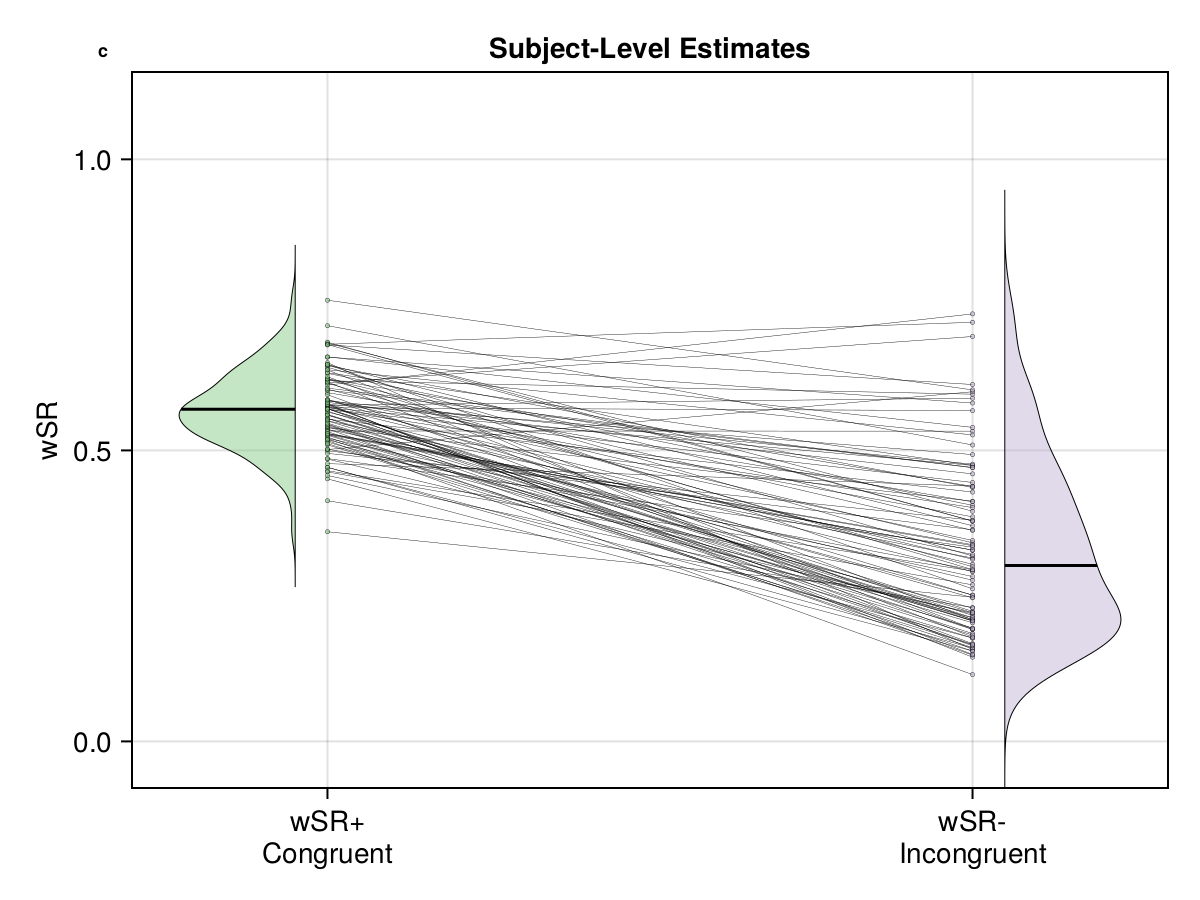

In [ ]:
# Plot
colors = categorical_colors(:Accent_6, 6)

r = load("$(outdir)$(ver).jld2", "results")
wSR1_ind = findfirst(x -> x == "wSR1", r.varnames)
wSR2_ind = findfirst(x -> x == "wSR2", r.varnames)

f = Figure(size=300 .* (2.0, 1.5))
ax = Axis(f[1,1], xticks = (1:2, ["wSR+\nCongruent", "wSR-\nIncongruent"]),
    ylabel="wSR",
    palette = (; patchcolor = colors),
    title = "Subject-Level Estimates",
)
x = repeat([1], inner=100) .- 0.05
violin!(x, unitnorm.(r.x[:,wSR1_ind]),
        side = :left,
        strokecolor = :black, strokewidth = 0.5,
        color=(colors[1], 0.45),
        width=0.45,
        show_median=true,
        mediancolor=:black,
)
x = repeat([2], inner=100) .+ 0.05
violin!(x, unitnorm.(r.x[:,wSR2_ind]),
        side = :right,
        strokecolor = :black, strokewidth = 0.5,
        color=(colors[2], 0.45),
        width=0.45,
        show_median=true,
        mediancolor=:black,
)
for i in 1:100
    lines!([1, 2], unitnorm.([r.x[i,wSR1_ind], r.x[i,wSR2_ind]]), color=:black, linewidth=0.2)
    scatter!([1], unitnorm.([r.x[i,wSR1_ind]]), color=(colors[1], 0.5), strokewidth=0.2, markersize=3)
    scatter!([2], unitnorm.([r.x[i,wSR2_ind]]), color=(colors[2], 0.5), strokewidth=0.2, markersize=3)
end
Label(f[1, 1, TopLeft()], "c", fontsize = 9, font = :bold, padding = (0, 12, 2, 0), halign = :right)
ylims!(-0.08, 1.15)
save("results/mbsr_blockwise_subjectlevel.pdf", f, pt_per_unit=1.0)
f
     
